## Question 1

In [48]:
import numpy as np 
import matplotlib.pyplot as plt 

# Define an array of four linestyles here for later use 
l_styles = ['solid', 'dotted', 'dashed', 'dashdot']

### Part 4

In [15]:
def eigen_vals(t, U):
    # Create hamiltonian matrix
    H = np.matrix(
        [
            [0, 0, -t, -t],
            [0, 0, t, t],
            [-t, t, U, 0],
            [-t, t, 0, U]
        ]
    )

    # Generate values and vectors
    H_values, H_vectors = np.linalg.eig(H)
    
    return H_values, H_vectors

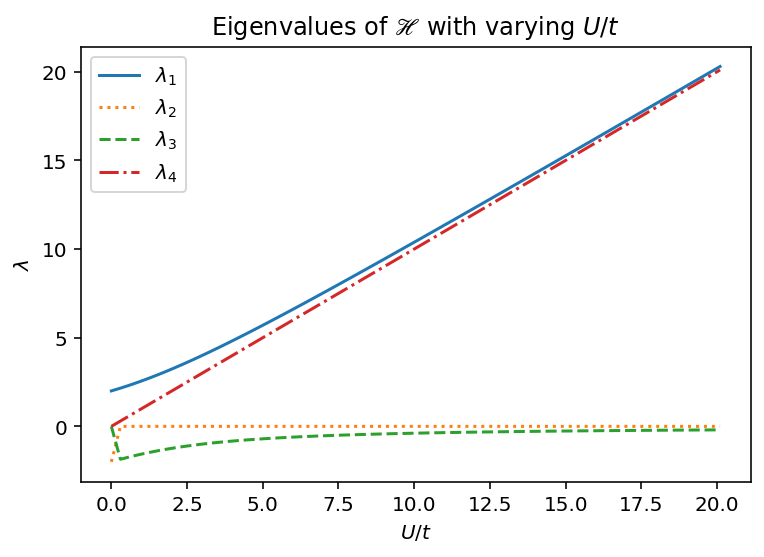

In [53]:
# Generate eigenvals for varying U/t and store them in an array
eigen_vals_array = []
spacing = 0.3
U_t_vals = np.arange(0, 20+spacing, spacing)

for val in U_t_vals:
    H_values, H_vectors = eigen_vals(1, val)
    eigen_vals_array.append(H_values)

# Convert to numpy array to make manipulation easier
eigen_vals_array = np.array(eigen_vals_array)

fig = plt.figure(dpi=144)

for index in range(0, 4):
    plt.plot(U_t_vals, eigen_vals_array[:, index], label=f'$\lambda_{index+1}$', linestyle=l_styles[index])
    
plt.title("Eigenvalues of $\mathscr{H}$ with varying $U/t$")
plt.xlabel("$U/t$")
plt.ylabel('$\lambda$')
plt.legend()

From this, we can see that $|\psi_0\rangle$ corresponds to $\lambda_3$. By finding the corresponding eigenvector for $\lambda_3$, we can find the probabilites of the ground state existing in any of the four basis states.

In [61]:
# Find the eigenvector of the groundstate 
# (correspond to the 3rd entry in both H_values and H_vectors )
H_values, H_vectors = eigen_vals(1, 1)
psi_0 = H_vectors[:, 2]

# Define the basis set
basis = np.eye(4)

def a_psi_projection(U_t_vals, basis):
    probabilities = []
    a_psi_projections = []
    
    for val in U_t_vals:
        H_values, H_vectors = eigen_vals(1, val)
        probability_for_val = []
        a_psi_projections_for_val = []
        
        for index in range(4):
            a_psi = basis[index] @ H_vectors[:, 2]
            probability = a_psi**2
            
            a_psi_projections_for_val.append(a_psi)
            probability_for_val.append(probability)    
        
        a_psi_projections.append(a_psi_projections_for_val)
        probabilities.append(probability_for_val)
    
    return np.array(a_psi_projections), np.array(probabilities)

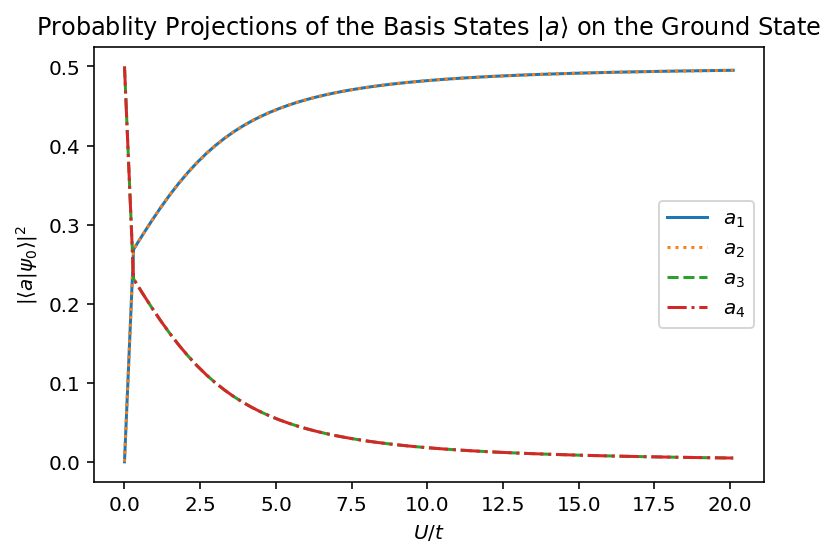

In [70]:
basis_state_projections, basis_state_probabilities = a_psi_projection(U_t_vals, basis)

fig = plt.figure(dpi=144)

for index in range(4):
    plt.plot(U_t_vals, np.squeeze(basis_state_probabilities[:, index]), label=f'$a_{index+1}$', linestyle=l_styles[index])
    
plt.xlabel('$U/t$')
plt.ylabel('$|\langle a | \psi_0 \\rangle |^2$')
plt.title('Probablity Projections of the Basis States $ |a\\rangle $ on the Ground State')
plt.legend()

From this graph, we see the groundstate becomes entierly composed of $|a_1\rangle$ and $|a_2 \rangle states$, which correspond to the $|\uparrow, \downarrow\rangle$ and $|\downarrow, \uparrow \rangle$ states respectively. This suggests $|\psi_0\rangle$ is tending towards one of two states: 

- $\frac{1}{\sqrt{2}}\{|\uparrow, \downarrow\rangle + |\downarrow, \uparrow \rangle\}$ (a triplet state)
- $\frac{1}{\sqrt{2}}\{|\uparrow, \downarrow\rangle - |\downarrow, \uparrow \rangle\}$ (a singlet state)

We can investigate which state it is tending towards using the humble print statement.

In [71]:
print(f'Basis state projections for U/t=20:\n {basis_state_projections[-1, :]}')

Basis state projections for U/t=20:
 [[[ 0.70369878]]

 [[-0.70369878]]

 [[ 0.06933993]]

 [[ 0.06933993]]]


From the printed out statement above, we can see $|\psi_0\rangle \to 0.7\{|\uparrow, \downarrow\rangle - |\downarrow, \uparrow \rangle\} \approx \frac{1}{\sqrt{2}}\{|\uparrow, \downarrow\rangle - |\downarrow, \uparrow \rangle\}$, suggesting that, as $U/t$ increases, the groundstate $|\psi_0\rangle$ tends to the singlet state.

## Question 2

### Part 2

In [55]:
N_s = 256 
j = np.arange(-N_s/2+1, N_s/2+1, 1)
k = (2*np.pi*j)/N_s
N = 128 

# Defining the algorithm
def E_against_M(k, N_s, N, t=1, U=0.1):
    '''
    Function that finds the minimum energy state of 
    the mean field Hamiltonian for a given t, and U 
    '''

    # Generate all N_up, N_down pairs
    N_up = np.arange(0, N+1, 1)
    N_down = np.flip(N_up)

    # Generate each mean field
    n_up = N_up/N_s
    n_down = N_down/N_s

    # Define energy eigenfunctions for each k 
    e_k = -2*t*np.cos(k)
        
    def E(k, N_up_val, N_down_val, n_up_val, n_down_val):
        '''
        Returns each E_sigma value summed up to the 
        N_sigma lowest energy state
        '''
        eMF_up = np.sort(e_k + U*n_down_val)
        eMF_down = np.sort(e_k + U*n_up_val)

        E_up = np.sum(eMF_up[:N_up_val])
        E_down = np.sum(eMF_down[:N_down_val])
        
        return E_up, E_down
        
    # Calculate ground state energy for each M 
    energy = []
    for index in range(N+1):
        E_up, E_down = E(k, N_up[index], N_down[index], n_up[index], n_down[index])
        new_energy = (E_up+E_down)/N_s - (U*n_up[index]*n_down[index])
        energy.append(new_energy)

    # Find the min E value and corresponding M
    min_energy = min(energy)
    min_index = energy.index(min_energy)
    min_M = (N_up[min_index] - N_down[min_index])/N

    # Calculate all M
    M = (N_up - N_down)/N
    
    return M, energy, min_M, min_energy

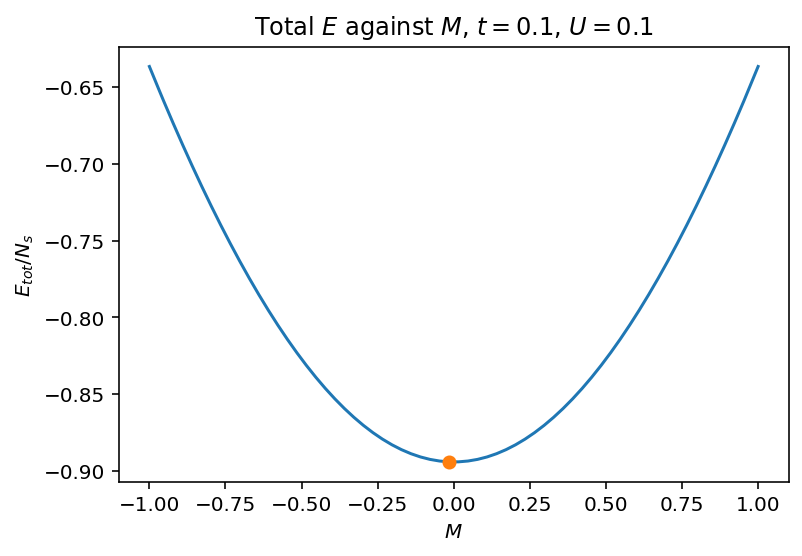

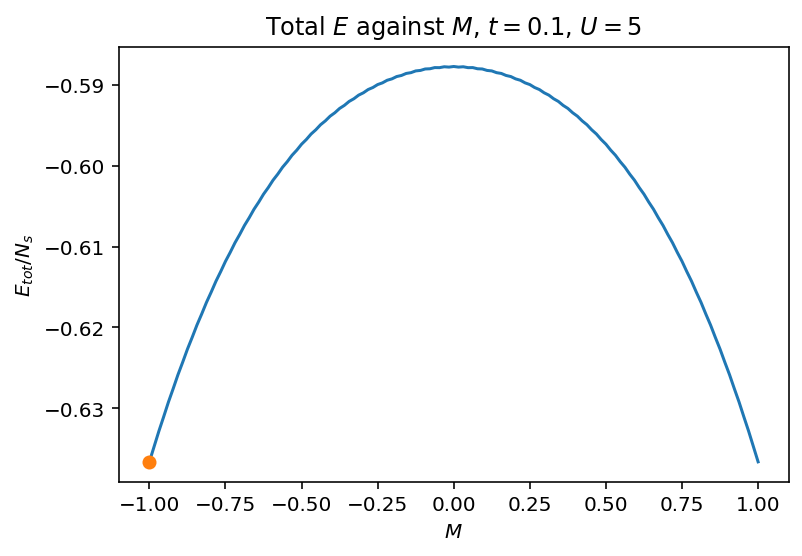

In [57]:
# --------------------- Part (e) --------------------------
# Plot below the Stoner Transition
M, energy, min_M, min_energy = E_against_M(k, N_s, N, t=1, U=0.1)

fig = plt.figure(dpi=144)
plt.title(f"Total $E$ against $M$, $t=0.1$, $U=0.1$")
plt.xlabel('$M$')
plt.ylabel('$E_{tot}/N_s$')
plt.plot(M, energy)
plt.plot(min_M, min_energy, marker='o')


# Plot above the Stoner Transition
M, energy, min_M, min_energy = E_against_M(k, N_s, N, t=1, U=5)

fig = plt.figure(dpi=144)
plt.title(f"Total $E$ against $M$, $t=0.1$, $U=5$")
plt.xlabel('$M$')
plt.ylabel('$E_{tot}/N_s$')
plt.plot(M, energy)
plt.plot(min_M, min_energy, marker='o')

### Part 3

In [59]:
# Generate minimum energy values
M_min_vals = []
U_vals = np.arange(2.1, 6, 0.1)
for U in U_vals:
    M, energy, min_M, min_energy = E_against_M(k, N_s, N, t=1, U=U)
    M_min_vals.append(min_M)

Text(0.5, 1.0, '$U$ as a Function of Energy-Minimising $M$ Values')

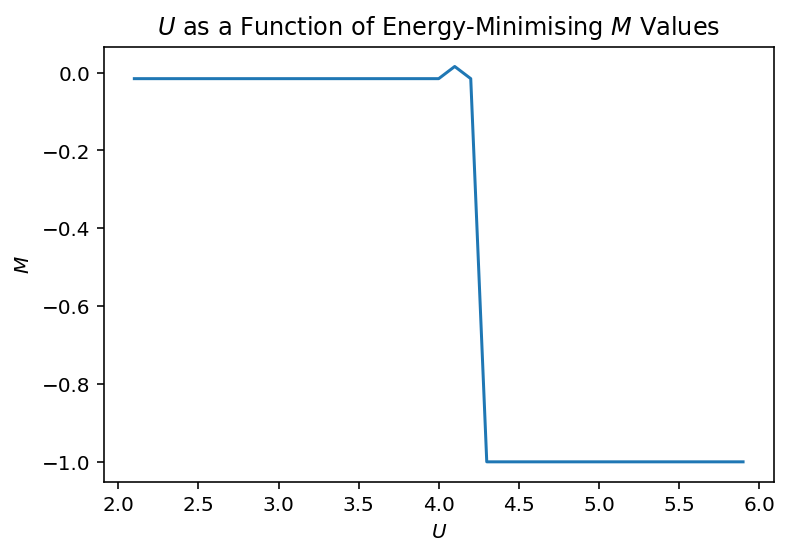

In [60]:
fig = plt.figure(dpi=144)
plt.plot(U_vals, M_min_vals)
plt.xlabel("$U$")
plt.ylabel("$M$")
plt.title("$U$ as a Function of Energy-Minimising $M$ Values")

From the plot above, we can estimate $U \approx 4.25$ as the critical $U$ value at which the magnetisation makes the transition from $M=0$ to a ferromagnet.